In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from Place import Sight, Hotel
from collections import namedtuple, defaultdict

In [2]:
interests = []
sights_list = []
sights_df = pd.read_json('sights.json')
for row in sights_df.itertuples():
    sights_list.append(Sight(row))

Location = namedtuple('Location', ['lat', 'lng'])
hotel = Hotel({'name': 'Dormy Inn Akihabara', 'location': Location(35.702540, 139.773290)})
hotel_list = [hotel]

In [3]:
def df_loc(place_list):
    df = pd.DataFrame(columns=['name', 'lat', 'lng'])
    for place in place_list:
        lat = float(place.location.lat)
        lng = float(place.location.lng)
        df = df.append(pd.Series({'name': place.name, 'lat': lat, 'lng': lng}), ignore_index=True)
    return df

sights_loc_df = df_loc(sights_list)
hotel_loc_df = df_loc(hotel_list)

In [4]:
df = sights_loc_df
offset = 0.01
print('\t\t{}\n{}\t\t\t{}\n\t\t{}'.format(df.lat.max() + offset, df.lng.min() - offset, \
                                          df.lng.max() + offset, df.lat.min() - offset))

bb = (df.lng.min() - offset, df.lng.max() + offset, \
      df.lat.min() - offset, df.lat.max() + offset)
print(bb)

		35.7431093
139.5604317			139.8207004
		35.609335900000005
(139.5604317, 139.8207004, 35.609335900000005, 35.7431093)


In [5]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [6]:
def print_solution(data, manager, routing, assignment):  # pylint:disable=too-many-locals
    print('Objective: {}'.format(assignment.ObjectiveValue()))
    total_distance = 0
    total_load = 0
    total_time = 0
    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    time_dimension = routing.GetDimensionOrDie('Time')
    for day in range(data['days']):
        index = routing.Start(day)
        plan_output = 'Route for day {}:\n'.format(day)
        distance = 0
        while not routing.IsEnd(index):
            load_var = capacity_dimension.CumulVar(index)
            time_var = time_dimension.CumulVar(index)
            slack_var = time_dimension.SlackVar(index)
            plan_output += ' {0} Load({1}) Time({2},{3}) Slack({4},{5}) ->'.format(
                manager.IndexToNode(index),
                assignment.Value(load_var),
                assignment.Min(time_var),
                assignment.Max(time_var),
                assignment.Min(slack_var), assignment.Max(slack_var))
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            distance += routing.GetArcCostForVehicle(previous_index, index,
                                                     day)
        load_var = capacity_dimension.CumulVar(index)
        time_var = time_dimension.CumulVar(index)
        slack_var = time_dimension.SlackVar(index)
        plan_output += ' {0} Load({1}) Time({2},{3})\n'.format(
            manager.IndexToNode(index),
            assignment.Value(load_var),
            assignment.Min(time_var), assignment.Max(time_var))
        plan_output += 'Distance of the route: {0}m\n'.format(distance)
        plan_output += 'Load of the route: {}\n'.format(
            assignment.Value(load_var))
        plan_output += 'Time of the route: {}\n'.format(
            assignment.Value(time_var))
        print(plan_output)
        total_distance += distance
        total_load += assignment.Value(load_var)
        total_time += assignment.Value(time_var)
    print('Total Distance of all routes: {0}m'.format(total_distance))
    print('Total Load of all routes: {}'.format(total_load))
    print('Total Time of all routes: {0}min'.format(total_time))

def haversine_distance(u,v):
    r = 6378.137
    [lat_u, lng_u] = u
    [lat_v, lng_v] = v
    lat_delta = lat_v - lat_u
    lng_delta = lng_v - lng_u
    a = (np.sin(np.radians(lat_delta/2))**2 + np.sin(np.radians(lng_delta/2))**2 * \
         np.cos(np.radians(lat_u)) * np.cos(np.radians(lat_v)))
    d = 2 * r * np.arcsin(np.sqrt(a))
    return d * 1000 #in metres


In [7]:
def create_data_model():
    data = {}
    sights_list = []
    sights_df = pd.read_json('sights.json')
    for row in sights_df.itertuples():
        sights_list.append(Sight(row))
    df = pd.DataFrame(columns=['name', 'lat', 'lng'])
    for place in sights_list:
        lat = float(place.location.lat)
        lng = float(place.location.lng)
        df = df.append(pd.Series({'name': place.name, 'lat': lat, 'lng': lng}), ignore_index=True)
    data['locations'] = []
    data['locations'].append((35.702540, 139.773290))
    data['locations'] += [(point.lat, point.lng) for point in df.itertuples()]
    data['num_locations'] = len(data['locations'])
    data['time_windows'] = [(0,0)] + [(0,480) for i in range(data['num_locations']-1)]
    data['visit_time'] = [0] + [90 for i in range(data['num_locations']-1)]
    data['stay_duration_days'] = 4
    data['available_time'] = [999 for i in range(data['stay_duration_days'])]
    data['hotel'] = 0
    return data

In [74]:
#Constraints
def haversine_distance(u,v):
    r = 6378.137
    [lat_u, lng_u] = u
    [lat_v, lng_v] = v
    lat_delta = lat_v - lat_u
    lng_delta = lng_v - lng_u
    a = (np.sin(np.radians(lat_delta/2))**2 + np.sin(np.radians(lng_delta/2))**2 * \
         np.cos(np.radians(lat_u)) * np.cos(np.radians(lat_v)))
    d = 2 * r * np.arcsin(np.sqrt(a))
    return d * 1000 #in metres

def gen_distance_matrix(data):
    distance_matrix = {}
    # precompute distance between location to have distance callback in O(1)
    for from_node in range(data['num_locations']):
        distance_matrix[from_node] = {}
        for to_node in range(data['num_locations']):
            if from_node == to_node:
                distance_matrix[from_node][to_node] = 0
            else:
                distance_matrix[from_node][to_node] = (haversine_distance(
                    data['locations'][from_node], data['locations'][to_node]))
    data['distance_matrix'] = distance_matrix
    return data


def add_capacity_constraints(routing, data, demand_evaluator_index):
    """Adds capacity constraint"""
    capacity = 'Capacity'
    routing.AddDimensionWithVehicleCapacity(
        demand_evaluator_index,
        0,  # capacity slack
        data['available_time'],
        True,  # start cumul to zero
        capacity)

def gen_time_matrix_wst(data):
    time_matrix = {}
    def travel_time(data, from_node, to_node):
        """Gets the travel times between two locations."""
        if from_node == to_node:
            travel_time = 0
        else:
            travel_time = haversine_distance(data['locations'][from_node], data[
                'locations'][to_node]) / 300
        return travel_time
    # precompute total time to have time callback in O(1)
    for from_node in range(data['num_locations']):
        time_matrix[from_node] = {}
        for to_node in range(data['num_locations']):
            if from_node == to_node:
                time_matrix[from_node][to_node] = 0
            else:
                time_matrix[from_node][to_node] = data['visit_time'][from_node] + travel_time(
                        data, from_node, to_node)
    data['time_matrix_wst'] = time_matrix

def add_time_window_constraints(routing, manager, data, time_evaluator_index):
    """Add Global Span constraint"""
    time = 'Time'
    routing.AddDimension(
        time_evaluator_index,
        15,  # allow waiting time
        420,  # maximum time per vehicle
        False,  # don't start cumul to zero since we are giving TW to start nodes
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except depot
    # Include slack in solution object
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
        routing.AddToAssignment(time_dimension.SlackVar(index))
    # Add time window constraints for each vehicle start node
    # Include slack in solution object
    for day in range(data['stay_duration_days']):
        index = routing.Start(day)
        time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0],
                                                data['time_windows'][0][1])
        routing.AddToAssignment(time_dimension.SlackVar(index))


def print_solution(data, manager, routing, assignment):  # pylint:disable=too-many-locals
    """Prints assignment on console"""
    print('Objective: {}'.format(assignment.ObjectiveValue()))
    total_distance = 0
    total_load = 0
    total_time = 0
    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    time_dimension = routing.GetDimensionOrDie('Time')
    for day in range(data['stay_duration_days']):
        index = routing.Start(day)
        plan_output = 'Route for vehicle {}:\n'.format(day)
        distance = 0
        while not routing.IsEnd(index):
            load_var = capacity_dimension.CumulVar(index)
            time_var = time_dimension.CumulVar(index)
            slack_var = time_dimension.SlackVar(index)
            plan_output += ' {0} Load({1}) Time({2},{3}) Slack({4},{5}) ->'.format(
                manager.IndexToNode(index),
                assignment.Value(load_var),
                assignment.Min(time_var),
                assignment.Max(time_var),
                assignment.Min(slack_var), assignment.Max(slack_var))
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            distance += routing.GetArcCostForVehicle(previous_index, index,
                                                     day)
        load_var = capacity_dimension.CumulVar(index)
        time_var = time_dimension.CumulVar(index)
        slack_var = time_dimension.SlackVar(index)
        plan_output += ' {0} Load({1}) Time({2},{3})\n'.format(
            manager.IndexToNode(index),
            assignment.Value(load_var),
            assignment.Min(time_var), assignment.Max(time_var))
        plan_output += 'Distance of the route: {0}m\n'.format(distance)
        plan_output += 'Load of the route: {} places\n'.format(
            assignment.Value(load_var))
        plan_output += 'Time of the route: {}min\n'.format(
            assignment.Value(time_var))
        print(plan_output)
        total_distance += distance
        total_load += assignment.Value(load_var)
        total_time += assignment.Value(time_var)
    print('Total Distance of all routes: {0}m'.format(total_distance))
    print('Total Load of all routes: {} places'.format(total_load))
    print('Total Time of all routes: {0}min'.format(total_time))

In [75]:
"""Entry point of the program"""
# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(data['num_locations'],
                                       data['stay_duration_days'], data['hotel'])

# Create Routing Model
routing = pywrapcp.RoutingModel(manager)

# Define weight of each edge
gen_distance_matrix(data)
def distance_callback(from_node, to_node):
    return data['distance_matrix'][manager.IndexToNode(from_node)][manager.IndexToNode(
        to_node)]
distance_evaluator_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(distance_evaluator_index)

# Add Capacity constraint
def cost_callback(from_node):
    return data['visit_time'][manager.IndexToNode(from_node)]
demand_evaluator_index = routing.RegisterUnaryTransitCallback(cost_callback)
add_capacity_constraints(routing, data, demand_evaluator_index)

# Add Time Window constraint
gen_time_matrix_wst(data)
def tw_callback(from_node, to_node):
    return data['time_matrix_wst'][manager.IndexToNode(from_node)][manager.IndexToNode(to_node)]
time_evaluator_index = routing.RegisterTransitCallback(tw_callback)
add_time_window_constraints(routing, manager, data, time_evaluator_index)

# Setting first solution heuristic (cheapest addition).
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)  # pylint: disable=no-member
# Solve the problem.
assignment = routing.SolveWithParameters(search_parameters)
if assignment:
    print_solution(data, manager, routing, assignment)
else:
    print('Failed to find solution')

Objective: 80970
Route for vehicle 0:
 0 Load(0) Time(0,0) Slack(0,15) -> 12 Load(0) Time(30,45) Slack(0,15) -> 8 Load(90) Time(188,218) Slack(0,15) -> 0 Load(180) Time(339,384)
Distance of the route: 48120m
Load of the route: 180 places
Time of the route: 339min

Route for vehicle 1:
 0 Load(0) Time(0,0) Slack(0,8) -> 4 Load(0) Time(8,16) Slack(0,8) -> 6 Load(90) Time(108,116) Slack(0,8) -> 10 Load(180) Time(206,214) Slack(0,8) -> 3 Load(270) Time(298,306) Slack(0,8) -> 0 Load(360) Time(412,420)
Distance of the route: 16486m
Load of the route: 360 places
Time of the route: 412min

Route for vehicle 2:
 0 Load(0) Time(0,0) Slack(0,15) -> 7 Load(0) Time(7,22) Slack(0,15) -> 11 Load(90) Time(97,127) Slack(0,15) -> 1 Load(180) Time(188,225) Slack(0,15) -> 2 Load(270) Time(282,319) Slack(0,15) -> 0 Load(360) Time(383,420)
Distance of the route: 7555m
Load of the route: 360 places
Time of the route: 383min

Route for vehicle 3:
 0 Load(0) Time(0,0) Slack(0,15) -> 9 Load(0) Time(7,22) Slack(

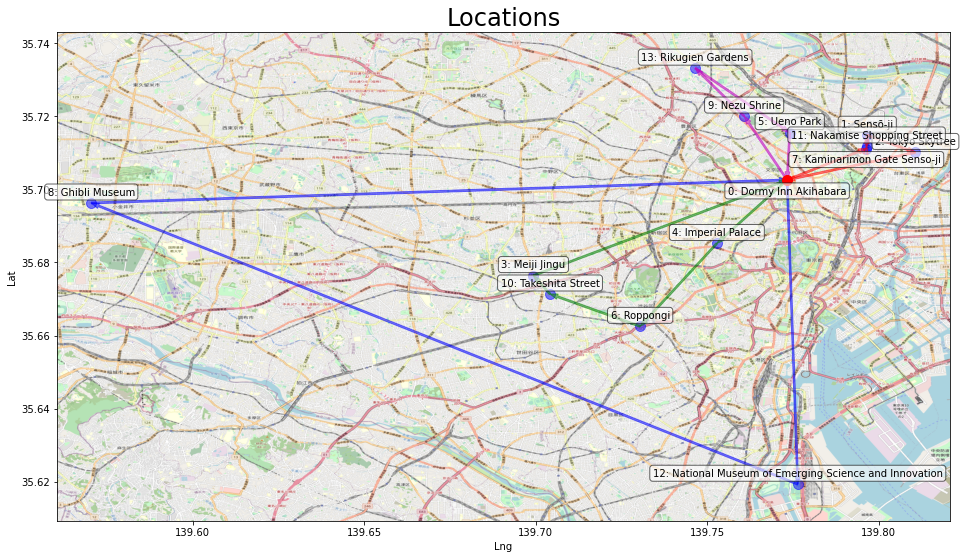

In [89]:
fig, ax = plt.subplots(figsize=(16, 9))
tokyo_map = plt.imread('tokyo_map.png')
styling = dict(boxstyle="round", alpha=0.6, facecolor='white')
plt.scatter(hotel_loc_df.lng, hotel_loc_df.lat, zorder=2, alpha=1, c='r', s=100)
plt.scatter(sights_loc_df.lng, sights_loc_df.lat, zorder=1, alpha=0.5, c='b', s=100)
ax.text(hotel.location.lng, hotel.location.lat-0.003, '{}: {}'.format(0, hotel.name), ha='center', va='center', bbox=styling)

for point in sights_loc_df.itertuples():
    if point.Index == 6:
        ax.text(point.lng, point.lat-0.003, '{}: {}'.format(point.Index+1, point.name), ha='center', va='center', bbox=styling)
        pass
    else:
        ax.text(point.lng, point.lat+0.003, '{}: {}'.format(point.Index+1, point.name), ha='center', va='center', bbox=styling)
        pass

cgroup = ['b', 'g', 'r', 'm', 'k']
for day in range(data['stay_duration_days']):
    index = routing.Start(day)
    start_x, start_y = data['locations'][0][1], data['locations'][0][0]
    while not routing.IsEnd(index):
        x, y = data['locations'][manager.IndexToNode(index)][1], data['locations'][manager.IndexToNode(index)][0]
        plt.arrow(start_x, start_y, x-start_x, y-start_y, length_includes_head=True, width=0.0005, alpha=0.5, color=cgroup[day])
        start_x, start_y = x, y
        index = assignment.Value(routing.NextVar(index))
    x, y = data['locations'][manager.IndexToNode(index)][1], data['locations'][manager.IndexToNode(index)][0]
    plt.arrow(start_x, start_y, x-start_x, y-start_y, length_includes_head=True, width=0.0005, alpha=0.5, color=cgroup[day])

ax.set_title('Locations', size=24)
ax.set_xlim(bb[0], bb[1])
ax.set_ylim(bb[2], bb[3])
ax.set_xlabel('Lng')
ax.set_ylabel('Lat')

ax.imshow(tokyo_map, zorder=0, extent=bb, aspect='auto')

plt.show()